In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from logger.new_callbacks import Callbacks

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook as tqdm
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
import torch
from utils.lr_finder import ExponentialLR, LinearLR

HAS_AMP =False

class BaseTrainer(object):
    def __init__(self):
        pass
    
    def batch_process(self, index=None, isTraining=True):
        raise NotImplementedError()
    
    def batch_train_step(self, batch, index):
        raise NotImplementedError()
        
    def batch_valid_step(self, batch, index):
        raise NotImplementedError()
        
    '''
    1. Train Main
    '''
    def train_on_dl(self):
        self.cb.on_train_dl_start()
        self.model.train()
        self.optimizer.zero_grad()
        for index, batch in enumerate(tqdm(self.trainloader)):
            self.batch_train(batch, index)

        self.cb.on_train_dl_end()

    '''
    1.1 Train Batch Main
    '''
    def batch_train(self, batch, index):
        self.cb.on_batch_train_start()

        batch = self.batch_process(batch, index, isTraining=True)
        loss = self.batch_train_step(batch, index)
        self.loss_backpass(loss)
        if (index+1)%self.grad_acc_num == 0:
            self.optimizer.step()
            if self.scheduler is not None:
                self.scheduler.step()
            self.optimizer.zero_grad()

        self.cb.on_batch_train_end()

    '''
    1.1.3. batch backpass
    '''
    def loss_backpass(self, loss):
        if HAS_AMP:
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
            
    '''
    2. Validation Main
    '''
    def valid_on_dl(self):
        self.cb.on_valid_dl_start()
        self.model.eval()
        with torch.no_grad():
            for index, batch in enumerate(tqdm(self.validloader)):
                self.batch_valid(batch, index)

        self.cb.on_valid_dl_end()

    '''
    2.1 Validation Batch Main
    '''
    def batch_valid(self, batch, index):
        self.cb.on_batch_valid_start()
        
        batch = self.batch_process(batch, index, isTraining=False)
        self.batch_valid_step(batch, index)

        self.cb.on_batch_valid_end()
    
    def train(self):
        for epoch in range(self.cb.epoch, self.epochs):
            self.cb.on_epoch_start()
            trainer.train_on_dl()
            trainer.valid_on_dl()
            self.cb.on_epoch_end()
    
    '''
    Use this method to ensure the model can actually overfit on one batch
    '''
    def train_on_sample(self, steps=100,batch=None):
        if batch is None:
            batch = next(iter(self.trainloader))
            
        self.cb.on_train_dl_start()
        self.model.train()
        self.optimizer.zero_grad()
        for i in tqdm(range(steps)):
            self.batch_train(batch, i)
        self.cb.on_train_dl_end()
        
        self.cb.on_valid_dl_start()
        self.model.eval()
        with torch.no_grad():
            self.batch_valid(batch, 0)
        self.cb.on_valid_dl_end()
        print("If running in a notebook, don't forget to reset the trainer")
    
    '''
    Use this method to find good learning rates
    '''
    def lr_finder(self, num_iter, start_lr, end_lr, step_mode="linear", stop_factor=5):
        self.init_optimizer(lr=start_lr)
        if step_mode.lower() == "exp":
            lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))
        iterator = iter(self.trainloader)
        self.scheduler = lr_schedule
        self.model.train()
        lrs = []
        losses = []
        min_loss = 100000
        min_lr = 1000
        counter = 0
        min_lr_index = 0
        for iteration in tqdm(range(num_iter)):
            try:
                batch = next(iterator)
            except StopIteration:
                iterator = iter(self.trainloader)
                batch = next(iterator)

            self.cb.on_train_dl_start()
            self.optimizer.zero_grad()
            self.batch_train(batch, iteration)
            lr = self.scheduler.get_lr()[0]
            loss = self.cb.logger.get("train_mean_loss")
            if loss < min_loss:
                min_loss = loss
                min_lr = lr
                min_lr_index = iteration
            if loss>min_loss*stop_factor:
                counter +=1
                if counter>5:
                    print(loss, min_loss)
                    print("MIN_LR (index):", min_lr, min_lr_index)
                    break
            else:
                counter = 0
            lrs.append(lr)
            losses.append(loss)
        print("If running in a notebook, don't forget to reset the trainer")
        return lrs, losses, min_lr_index

In [6]:
class Trainer(BaseTrainer):
    def __init__(self):
        self.model = Net()
        self.trainloader = trainloader
        self.validloader = testloader
        self.cb = Callbacks()
        self.grad_acc_num = 1
        self.scheduler = None
        self.epochs = 2
        
        self.criterion = nn.CrossEntropyLoss()
        
        self.lr = 0.005
        self.init_optimizer()
    
    def init_optimizer(self, lr=None):
        if lr is not None:
            self.lr = lr
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        
    '''
    1.1.1. batch process
    '''
    def batch_process(self, batch, index=None, isTraining=True):
        self.cb.on_batch_process_start()

        self.cb.on_batch_process_end()
        return batch

    '''
    1.1.2. batch train
    '''
    def batch_train_step(self, batch, index):
        self.cb.on_batch_train_step_start()
        
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels)
        
        if self.scheduler is not None:
            self.cb.on_batch_train_step_end({"train_batch_loss":loss.item(), "lr":self.scheduler.get_lr()[0]})
        else:
            self.cb.on_batch_train_step_end({"train_batch_loss":loss.item()})
        return loss
    
    '''
    2.1.2. batch valid
    '''
    def batch_valid_step(self, batch, index):
        self.cb.on_batch_valid_step_start()
        
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels)

        self.cb.on_batch_valid_step_end({"valid_batch_loss":loss.item()})

In [7]:
trainer = Trainer()

In [20]:
# trainer.train_on_sample(steps=1000)

In [ ]:
trainer.train()

0 {'train_batch_loss': 2.273792266845703, 'train_iter_mean_loss': 2.273792266845703, 'custom_step': 0}
100 {'train_batch_loss': 2.3322861194610596, 'train_iter_mean_loss': 2.3065974075015214, 'custom_step': 100}
200 {'train_batch_loss': 2.3301515579223633, 'train_iter_mean_loss': 2.2991940488862754, 'custom_step': 200}
300 {'train_batch_loss': 2.212006092071533, 'train_iter_mean_loss': 2.267383977028224, 'custom_step': 300}
400 {'train_batch_loss': 2.0990285873413086, 'train_iter_mean_loss': 2.2335779791758252, 'custom_step': 400}
500 {'train_batch_loss': 2.3370885848999023, 'train_iter_mean_loss': 2.211987233209514, 'custom_step': 500}
600 {'train_batch_loss': 2.2334938049316406, 'train_iter_mean_loss': 2.192808302785713, 'custom_step': 600}
700 {'train_batch_loss': 1.2546309232711792, 'train_iter_mean_loss': 2.172549790390551, 'custom_step': 700}
800 {'train_batch_loss': 1.7369790077209473, 'train_iter_mean_loss': 2.1526089018203822, 'custom_step': 800}
900 {'train_batch_loss': 2.242

7400 {'train_batch_loss': 1.2131843566894531, 'train_iter_mean_loss': 1.7904960432176322, 'custom_step': 7400}
7500 {'train_batch_loss': 1.1361470222473145, 'train_iter_mean_loss': 1.7877147594557945, 'custom_step': 7500}
7600 {'train_batch_loss': 1.8395122289657593, 'train_iter_mean_loss': 1.7859743400759296, 'custom_step': 7600}
7700 {'train_batch_loss': 2.6162562370300293, 'train_iter_mean_loss': 1.7845527560211534, 'custom_step': 7700}
7800 {'train_batch_loss': 1.9771907329559326, 'train_iter_mean_loss': 1.782495695999717, 'custom_step': 7800}
7900 {'train_batch_loss': 1.9273680448532104, 'train_iter_mean_loss': 1.7804792926607522, 'custom_step': 7900}
8000 {'train_batch_loss': 1.3006048202514648, 'train_iter_mean_loss': 1.7787229333977568, 'custom_step': 8000}
8100 {'train_batch_loss': 1.5899714231491089, 'train_iter_mean_loss': 1.7765093256758844, 'custom_step': 8100}
8200 {'train_batch_loss': 1.6868624687194824, 'train_iter_mean_loss': 1.7742939196466145, 'custom_step': 8200}
83


VALID: 0 12500 1.62310694320798
SAVING MODEL 0 12500


12500 {'train_batch_loss': 1.1552295684814453, 'train_iter_mean_loss': 1.1552295684814453, 'custom_step': 12500}
12600 {'train_batch_loss': 0.8528430461883545, 'train_iter_mean_loss': 1.513584846022105, 'custom_step': 12600}
12700 {'train_batch_loss': 1.1346073150634766, 'train_iter_mean_loss': 1.5196418547215151, 'custom_step': 12700}
12800 {'train_batch_loss': 1.4583455324172974, 'train_iter_mean_loss': 1.5514519884934845, 'custom_step': 12800}
12900 {'train_batch_loss': 2.9721405506134033, 'train_iter_mean_loss': 1.546408170253558, 'custom_step': 12900}
13000 {'train_batch_loss': 1.5880690813064575, 'train_iter_mean_loss': 1.541686099624919, 'custom_step': 13000}
13100 {'train_batch_loss': 1.6936709880828857, 'train_iter_mean_loss': 1.5497314799546005, 'custom_step': 13100}
13200 {'train_batch_loss': 1.133108377456665, 'train_iter_mean_loss': 1.5628903157445744, 'custom_step': 13200}
13300 {'train_batch_loss': 2.471050262451172, 'train_iter_mean_loss': 1.5668309499485225, 'custom_st

19700 {'train_batch_loss': 1.845503330230713, 'train_iter_mean_loss': 1.5915505673455463, 'custom_step': 19700}
19800 {'train_batch_loss': 2.2130484580993652, 'train_iter_mean_loss': 1.590569255893208, 'custom_step': 19800}
19900 {'train_batch_loss': 2.121232748031616, 'train_iter_mean_loss': 1.5914316337332695, 'custom_step': 19900}
20000 {'train_batch_loss': 1.2543208599090576, 'train_iter_mean_loss': 1.5919980718193683, 'custom_step': 20000}
20100 {'train_batch_loss': 1.8528354167938232, 'train_iter_mean_loss': 1.5921520894196581, 'custom_step': 20100}
20200 {'train_batch_loss': 2.59503173828125, 'train_iter_mean_loss': 1.591819870870173, 'custom_step': 20200}
20300 {'train_batch_loss': 0.5575294494628906, 'train_iter_mean_loss': 1.5915346680799547, 'custom_step': 20300}
20400 {'train_batch_loss': 1.4886705875396729, 'train_iter_mean_loss': 1.5904304298675176, 'custom_step': 20400}
20500 {'train_batch_loss': 1.8917330503463745, 'train_iter_mean_loss': 1.5917639063549975, 'custom_ste

In [22]:
num_iter = 10000
start_lr = 0.0001
end_lr = 10.0
step_mode = "exp"
stop_factor = 5
lrs, losses, min_lr_index = trainer.lr_finder(num_iter, start_lr, end_lr, step_mode, stop_factor)

0 {'train_batch_loss': 2.2931594848632812, 'lr': 0.0001001151955538169, 'train_iter_mean_loss': 2.2931594848632812, 'custom_step': 0}
100 {'train_batch_loss': 2.284403085708618, 'lr': 0.00011233109696743242, 'train_iter_mean_loss': 2.284403085708618, 'custom_step': 100}
200 {'train_batch_loss': 2.307891368865967, 'lr': 0.00012603756378944253, 'train_iter_mean_loss': 2.307891368865967, 'custom_step': 200}
300 {'train_batch_loss': 2.2975335121154785, 'lr': 0.0001414164725070154, 'train_iter_mean_loss': 2.2975335121154785, 'custom_step': 300}
400 {'train_batch_loss': 2.271332263946533, 'lr': 0.00015867189189515751, 'train_iter_mean_loss': 2.271332263946533, 'custom_step': 400}
500 {'train_batch_loss': 2.34689998626709, 'lr': 0.00017803279088537288, 'train_iter_mean_loss': 2.34689998626709, 'custom_step': 500}
600 {'train_batch_loss': 2.276411294937134, 'lr': 0.0001997560768442708, 'train_iter_mean_loss': 2.276411294937134, 'custom_step': 600}
700 {'train_batch_loss': 2.269848346710205, 'l

5900 {'train_batch_loss': 2.2512118816375732, 'lr': 0.08922776195878265, 'train_iter_mean_loss': 2.2512118816375732, 'custom_step': 5900}
6000 {'train_batch_loss': 2.154963254928589, 'lr': 0.10011519555381686, 'train_iter_mean_loss': 2.154963254928589, 'custom_step': 6000}
6100 {'train_batch_loss': 2.307511568069458, 'lr': 0.1123310969674324, 'train_iter_mean_loss': 2.307511568069458, 'custom_step': 6100}
6200 {'train_batch_loss': 2.8998208045959473, 'lr': 0.12603756378944247, 'train_iter_mean_loss': 2.8998208045959473, 'custom_step': 6200}
6300 {'train_batch_loss': 2.3982043266296387, 'lr': 0.1414164725070154, 'train_iter_mean_loss': 2.3982043266296387, 'custom_step': 6300}
6400 {'train_batch_loss': 2.16931414604187, 'lr': 0.15867189189515754, 'train_iter_mean_loss': 2.16931414604187, 'custom_step': 6400}
6500 {'train_batch_loss': 2.4666337966918945, 'lr': 0.1780327908853729, 'train_iter_mean_loss': 2.4666337966918945, 'custom_step': 6500}
6600 {'train_batch_loss': 2.5789620876312256,

In [23]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

(1.5, 2.9)

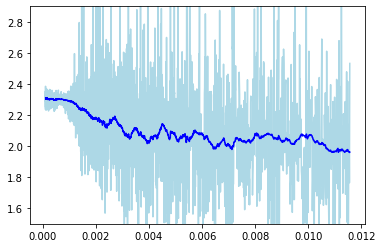

In [35]:
df = pd.DataFrame({"loss":losses, "lr":lrs})
df = df[0:min_lr_index]
df = df.set_index("lr")
plt.plot(df["loss"], 'lightblue', df["loss"].rolling(100).mean(), 'b');
plt.ylim(1.5,2.9)